In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

# Set a random seed for reproducibility
np.random.seed(35)


In [ ]:
# --- Configuration ---

# Define the file path to the dataset
FILE_PATH = '../data/preprocessed/final_nfi_ch2018_merged/NFI_with_Climate_Averages_RCP45.csv'

# Define features and targets 
FEATURES = [
    'mean_dry_days_count', 'mean_frost_days_count', 'mean_gdd_sum',
    'mean_pr_sum', 'mean_pr_variance', 'mean_tas_mean', 'mean_tas_variance',
    'mean_tasmax_mean', 'mean_tasmax_variance', 'mean_tasmin_mean',
    'mean_tasmin_variance', 'HWSW_prop', 'INVYR', 'BASFPH_squared',
    'Time_Diff_years', 'BASFPH', 'BEWIRTINT1', 'ASPECT25',
    'SLOPE25', 'PH', 'Z25', 'NAISHSTKOMB'
]
CATEGORICAL_FEATURES = ['BEWIRTINT1', 'NAISHSTKOMB']
TARGETS = ['BASFPH_next_INVNR', 'HWSW_prop_next_INVNR']

# Columns to group the evaluation by
GROUPING_COLUMNS = ['BEWIRTINT1', 'NAISHSTKOMB']


# Best Hyperparameters recieved from tuning
BEST_HYPERPARAMS = {
    'BASFPH_next_INVNR': {
        'Lasso': {
            'alpha': 0.01698333601900430  
        },
        'XGBoost': {
            'n_estimators': 528,
            'learning_rate': 0.01729584372942580,
            'max_depth': 4,
            'min_child_weight': 7,
            'subsample': 0.915671000069881,
            'colsample_bytree': 0.5079492554169410,
            'gamma': 1.87545677743196e-08,
            'reg_lambda': 0.08815827186283730,
            'reg_alpha': 1.22593393905332e-06
        }
    },
    'HWSW_prop_next_INVNR': {
        'Lasso': {
            'alpha': 0.00028909867726205900  
        },
        'XGBoost': {
            'n_estimators': 624,
            'learning_rate': 0.010780463059552800,
            'max_depth': 4,
            'min_child_weight': 2,
            'subsample': 0.6140111307693800,
            'colsample_bytree': 0.983498382979487,
            'gamma': 3.58420754960584e-05,
            'reg_lambda': 0.5579252558267870,
            'reg_alpha': 0.9910402451464640
        }
    }
}


In [24]:
def load_and_prepare_data(filepath, features_list, cat_features, targets_list):
    """
    Loads data, cleans it, performs one-hot encoding on TRAIN ONLY, and splits into
    training (INVNR 150, 250, 350) and testing (INVNR 450) sets.

    Returns original and processed dataframes for both train and test sets.
    """
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None, None, None, None, None, None
    print(len(df['CLNR'].unique()), "unique CLNR values after 100.")
    
    # Basic cleaning
    df = df[df['BASFPH'] <= 100].copy()
    df = df[df['BASFPH_next_INVNR'] <= 100].copy()
    print(len(df['CLNR'].unique()), "unique CLNR values after 100.")

    # Keep only desired inventory numbers
    invnr_to_keep = [150, 250, 350, 450]
    df_filtered = df[df['INVNR'].isin(invnr_to_keep)].copy()
    print(f"Filtered for INVNRs {invnr_to_keep}. Kept {len(df_filtered)} rows.")

    # Drop rows with missing values in any used feature/target
    columns_to_check_for_na = features_list + targets_list
    initial_rows = len(df_filtered)
    df_clean = df_filtered.dropna(subset=columns_to_check_for_na).copy()
    rows_after_drop = len(df_clean)
    print(f"Dropped {initial_rows - rows_after_drop} rows with NAs in features/targets.")

    print(len(df_clean['CLNR'].unique()), "unique CLNR values found in the dataset.")

    # TRAIN/TEST split based on INVNR
    train_df_original = df_clean[df_clean['INVNR'] != 450].copy()
    test_df_original  = df_clean[df_clean['INVNR'] == 450].copy()

    # Lock category levels from TRAIN, then apply to TEST
    for col in cat_features:
        # categories observed in TRAIN only
        cats = pd.Series(train_df_original[col]).dropna().unique()
        train_df_original[col] = pd.Categorical(train_df_original[col], categories=cats)
        test_df_original[col]  = pd.Categorical(test_df_original[col],  categories=cats)

    # One-hot encode TRAIN and TEST separately (using TRAIN categories). Apperently this is the standard way to do it.
    train_ohe = pd.get_dummies(train_df_original, columns=cat_features, drop_first=True) #drop_first: avoids perfect multicollinearity.
    test_ohe  = pd.get_dummies(test_df_original,  columns=cat_features, drop_first=True)

    # Build final feature list from TRAIN only
    numeric_features = [f for f in features_list if f not in cat_features]
    prefixes = tuple(c + "_" for c in cat_features)
    ohe_features = [c for c in train_ohe.columns if c.startswith(prefixes)]
    final_features = numeric_features + ohe_features
    print(f"Total number of features after encoding (from TRAIN): {len(final_features)}")

    # Feature matrices and target vectors
    # Align TEST columns to TRAIN's feature space (unknown cats in TEST -> all zeros (safety)(doesnt apply))
    X_train = train_ohe[final_features]
    X_test  = test_ohe.reindex(columns=final_features, fill_value=0)

    y_train = train_df_original[targets_list].copy()
    y_test  = test_df_original[targets_list].copy()

    print(f"\nTraining set size: {len(X_train)} rows")
    print(f"Test set size: {len(X_test)} rows")

    print("\nData preparation complete.")
    return X_train, y_train, X_test, y_test, train_df_original, test_df_original



def calculate_all_metrics(y_true, y_pred, group_name="Overall"):
    """Return basic regression metrics as a dict for one group."""

    # Ensure numpy arrays    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Calculate metrics
    metrics = {'Group': group_name, 'N': len(y_true)}
    mean_observed = y_true.mean()
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['R_squared'] = r2_score(y_true, y_pred)
    metrics['Bias'] = np.mean(y_pred - y_true)
    
    if mean_observed != 0:
        metrics['%RMSE'] = (metrics['RMSE'] / abs(mean_observed)) * 100
        metrics['%Bias'] = (metrics['Bias'] / mean_observed) * 100
    else: # avoid division by zero
        metrics['%RMSE'], metrics['%Bias'] = np.nan, np.nan
        
    return metrics

def train_and_evaluate_models(X_train, y_train, X_test, y_test, train_df_original, test_df_original, hyperparams_dict, grouping_cols):
    """
    Train Lasso and XGBoost per target, evaluate on train/test (overall and by groups),
    store predictions for plotting, and collect feature importances.
    """
    if X_train is None: # safety check
        print("Cannot proceed with training, data is missing.")
        return None, None, None

    all_results = []          # rows of metric dicts -> DataFrame at the end
    plot_data = {}            # test-set y_true and predictions by model
    feature_importances = {}  # per target per model
    
    # Loop over each target column
    for target in y_train.columns:
        print("\n" + "-"*70)
        print(f"##  Processing Target: {target}")
        print("-"*70)

        plot_data[target] = {}
        feature_importances[target] = {}

        # Define models with their hyperparameters
        models_to_run = {
            "Lasso": Pipeline([
                ('scaler', StandardScaler()),
                ('lasso', Lasso(**hyperparams_dict[target]['Lasso'], max_iter=10000))
            ]),
            "XGBoost": xgb.XGBRegressor(
                **hyperparams_dict[target]['XGBoost'],
                objective='reg:squarederror', random_state=35, n_jobs=-1,
                importance_type='gain'
            )
        }

        # Train and evaluate each model
        for model_name, model in models_to_run.items():
            print(f"\n--- Training and Evaluating {model_name} ---")
            
            #fit model
            model.fit(X_train, y_train[target])

            # Feature Importances
            if model_name == 'Lasso':
                # Absolute coef values from the lasso step (after scaling)
                importances = np.abs(model.named_steps['lasso'].coef_)
            elif model_name == 'XGBoost':
                # Built-in feature importance (gain)
                importances = model.feature_importances_
            
            # Store as a sorted Series (descending)
            feat_imp_series = pd.Series(importances, index=X_train.columns)
            feature_importances[target][model_name] = feat_imp_series.sort_values(ascending=False)

            # Evaluate on train and test
            datasets_to_evaluate = [
                ('Train', X_train, y_train[target], train_df_original),
                ('Test', X_test, y_test[target], test_df_original)
            ]
            
            for d_name, d_X, d_y_true, d_original_df in datasets_to_evaluate:
                if d_X.empty or d_y_true.empty: # skip empty splits (safety)
                    continue

                # Predict and clip to valid range (target-dependent) #cliping is not done in hyperparameter tuning, i hope it doesnt make a significant difference. I didnt do because lassoCV doesnt accept custom scoring function.
                raw_predictions = model.predict(d_X)
                if target == 'BASFPH_next_INVNR':
                    predictions = np.clip(raw_predictions, 0, 100)
                elif target == 'HWSW_prop_next_INVNR':
                    predictions = np.clip(raw_predictions, 0, 1)
                else: 
                    predictions = raw_predictions

                # Save test-set arrays for plotting later
                if d_name == 'Test':
                    if 'y_true' not in plot_data[target]:
                        plot_data[target]['y_true'] = d_y_true.values
                    plot_data[target][model_name] = predictions
                
                # Build eval frame to support grouped metrics
                eval_df = d_original_df.copy()
                eval_df['y_true'] = d_y_true.values
                eval_df['predictions'] = predictions
                
                # Overall metrics
                overall_metrics = calculate_all_metrics(eval_df['y_true'], eval_df['predictions'], group_name='Overall')
                if overall_metrics:
                    overall_metrics.update({'Target': target, 'Model': model_name, 'DataSet': d_name}) # update adds key/value pairs if they dont exist
                    all_results.append(overall_metrics)
                
                # Grouped metrics (by each grouping column and its categories)
                for group_col in grouping_cols:
                    if group_col in eval_df.columns:
                        for group_value in sorted(eval_df[group_col].unique()):
                            group_df = eval_df[eval_df[group_col] == group_value]
                            group_metrics = calculate_all_metrics(group_df['y_true'], group_df['predictions'], group_name=f"{group_col}_{group_value}")
                            if group_metrics:
                                group_metrics.update({'Target': target, 'Model': model_name, 'DataSet': d_name})
                                all_results.append(group_metrics)

    # Return metrics table, plotting payload, and importances
    return pd.DataFrame(all_results), plot_data, feature_importances

In [25]:
# Load and prepare data
X_train, y_train, X_test, y_test, train_df_original, test_df_original = load_and_prepare_data(
    FILE_PATH, FEATURES, CATEGORICAL_FEATURES, TARGETS
)


# Run the training and evaluation, capturing metrics, plot data, AND feature importances
evaluation_results_df, plot_data, feature_importances = train_and_evaluate_models(
    X_train, y_train, X_test, y_test, train_df_original, test_df_original, BEST_HYPERPARAMS, GROUPING_COLUMNS
)

# Display the detailed metrics
print("\n\n" + "-"*70)
print("##           FINAL MODEL PERFORMANCE SUMMARY")
print("-"*70)

metric_cols = ['N', 'RMSE', '%RMSE', 'R_squared', 'Bias', '%Bias']

for target in evaluation_results_df['Target'].unique():
    for model in evaluation_results_df['Model'].unique():
        
        subset_df = evaluation_results_df[
            (evaluation_results_df['Target'] == target) & 
            (evaluation_results_df['Model'] == model)
        ]
        
        if not subset_df.empty:
            train_results_df = subset_df[subset_df['DataSet'] == 'Train']
            if not train_results_df.empty:
                print(f"\n{target}: {model}: Training Set Metrics (on INVNR 150, 250, 350)")
                display(train_results_df.set_index('Group')[metric_cols])
            
            test_results_df = subset_df[subset_df['DataSet'] == 'Test']
            if not test_results_df.empty:
                print(f"\n{target}: {model}: Test Set Metrics (on INVNR 450)")
                display(test_results_df.set_index('Group')[metric_cols])
        else:
            print("No results to display for this combination.")
else:
    print("\nNo evaluation results were generated.")

Loading data from ../data/preprocessed/final_nfi_ch2018_merged/NFI_with_Climate_Averages_RCP45.csv...
4080 unique CLNR values after 100.
4063 unique CLNR values after 100.
Filtered for INVNRs [150, 250, 350, 450]. Kept 15516 rows.
Dropped 0 rows with NAs in features/targets.
4063 unique CLNR values found in the dataset.
Total number of features after encoding (from TRAIN): 31

Training set size: 11601 rows
Test set size: 3915 rows

Data preparation complete.

----------------------------------------------------------------------
##  Processing Target: BASFPH_next_INVNR
----------------------------------------------------------------------

--- Training and Evaluating Lasso ---

--- Training and Evaluating XGBoost ---

----------------------------------------------------------------------
##  Processing Target: HWSW_prop_next_INVNR
----------------------------------------------------------------------

--- Training and Evaluating Lasso ---

--- Training and Evaluating XGBoost ---


----

,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,11601,10.831815,32.875861,0.624560,0.005634,0.017099
BEWIRTINT1_1.0,7984,11.104942,33.782608,0.598949,0.011017,0.033516
BEWIRTINT1_2.0,1927,11.800176,33.246402,0.570741,-0.035137,-0.098998
BEWIRTINT1_3.0,1690,8.002079,26.319584,0.792628,0.026688,0.087779
NAISHSTKOMB_1,287,5.962890,23.029061,0.769405,0.106666,0.411952
NAISHSTKOMB_2,1092,9.225901,26.929592,0.740556,0.063849,0.186369
NAISHSTKOMB_3,1931,10.114611,30.535399,0.700900,0.048128,0.145296
NAISHSTKOMB_4,2284,11.079232,31.544145,0.627510,0.037699,0.107334
NAISHSTKOMB_5,2446,11.897914,33.270729,0.562968,-0.171465,-0.479476



BASFPH_next_INVNR: Lasso: Test Set Metrics (on INVNR 450)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,3915,10.663697,32.693358,0.646118,-1.822084,-5.586247
BEWIRTINT1_1.0,2499,11.087371,35.672121,0.594418,-1.806977,-5.813704
BEWIRTINT1_2.0,661,11.160648,31.115443,0.640917,-1.113668,-3.104863
BEWIRTINT1_3.0,755,8.585853,24.633120,0.781428,-2.492304,-7.150510
NAISHSTKOMB_1,113,6.801492,23.363020,0.744419,-3.404914,-11.695825
NAISHSTKOMB_2,387,9.606120,26.480615,0.755748,-2.699652,-7.441968
NAISHSTKOMB_3,657,9.783621,28.583876,0.722685,-2.736439,-7.994795
NAISHSTKOMB_4,761,11.185474,31.117922,0.644940,-1.865407,-5.189552
NAISHSTKOMB_5,805,12.056973,35.627706,0.560064,-1.170177,-3.457809



BASFPH_next_INVNR: XGBoost: Training Set Metrics (on INVNR 150, 250, 350)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,11601,9.633879,29.239982,0.703011,-0.000846,-0.002569
BEWIRTINT1_1.0,7984,9.942877,30.247461,0.678492,0.024316,0.073974
BEWIRTINT1_2.0,1927,10.470908,29.501254,0.662005,0.012094,0.034074
BEWIRTINT1_3.0,1690,6.711595,22.075062,0.854120,-0.134477,-0.442306
NAISHSTKOMB_1,287,5.223558,20.173715,0.823043,0.259867,1.003623
NAISHSTKOMB_2,1092,7.873190,22.981149,0.811058,-0.029126,-0.085018
NAISHSTKOMB_3,1931,8.869860,26.777569,0.769988,0.063499,0.191699
NAISHSTKOMB_4,2284,10.248979,29.180299,0.681245,0.076614,0.218131
NAISHSTKOMB_5,2446,10.580017,29.585427,0.654424,-0.156432,-0.437440



BASFPH_next_INVNR: XGBoost: Test Set Metrics (on INVNR 450)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,3915,10.460371,32.069991,0.659484,0.858562,2.632227
BEWIRTINT1_1.0,2499,10.900630,35.071310,0.607965,0.812193,2.613120
BEWIRTINT1_2.0,661,11.246457,31.354674,0.635374,1.670911,4.658435
BEWIRTINT1_3.0,755,7.959430,22.835890,0.812158,0.300832,0.863099
NAISHSTKOMB_1,113,5.287240,18.161589,0.845554,-0.688102,-2.363621
NAISHSTKOMB_2,387,8.898097,24.528849,0.790426,0.024518,0.067587
NAISHSTKOMB_3,657,9.295758,27.158533,0.749652,0.137680,0.402246
NAISHSTKOMB_4,761,11.103628,30.890226,0.650117,0.943760,2.625534
NAISHSTKOMB_5,805,12.174034,35.973613,0.551480,1.408626,4.162415



HWSW_prop_next_INVNR: Lasso: Training Set Metrics (on INVNR 150, 250, 350)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,11601,0.132565,35.329181,0.886521,0.000704,0.187640
BEWIRTINT1_1.0,7984,0.138507,40.072609,0.863559,0.001115,0.322628
BEWIRTINT1_2.0,1927,0.137538,30.004244,0.885833,-0.000433,-0.094381
BEWIRTINT1_3.0,1690,0.091824,21.853943,0.956942,0.000058,0.013866
NAISHSTKOMB_1,287,0.054464,1771.644525,-3.868240,0.007348,239.007615
NAISHSTKOMB_2,1092,0.038336,325.138544,0.726053,0.006131,52.000011
NAISHSTKOMB_3,1931,0.099432,87.816874,0.865492,0.001990,1.757815
NAISHSTKOMB_4,2284,0.128718,47.163878,0.820308,0.000587,0.215058
NAISHSTKOMB_5,2446,0.159189,32.925078,0.790041,-0.000448,-0.092753



HWSW_prop_next_INVNR: Lasso: Test Set Metrics (on INVNR 450)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,3915,0.123600,31.913259,0.902542,0.010983,2.835820
BEWIRTINT1_1.0,2499,0.138724,37.635677,0.867467,0.013426,3.642562
BEWIRTINT1_2.0,661,0.111039,24.616665,0.921420,0.006309,1.398708
BEWIRTINT1_3.0,755,0.068741,17.474974,0.975142,0.006988,1.776463
NAISHSTKOMB_1,113,0.016115,350.655169,0.676518,0.007836,170.507875
NAISHSTKOMB_2,387,0.042655,358.170341,0.704853,0.007543,63.341228
NAISHSTKOMB_3,657,0.067155,60.419289,0.933834,0.010561,9.501533
NAISHSTKOMB_4,761,0.116824,39.959267,0.853141,0.010584,3.620119
NAISHSTKOMB_5,805,0.142576,28.100713,0.829053,0.014076,2.774262



HWSW_prop_next_INVNR: XGBoost: Training Set Metrics (on INVNR 150, 250, 350)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,11601,0.117652,31.354732,0.910617,0.000238,0.063346
BEWIRTINT1_1.0,7984,0.122649,35.484540,0.893014,0.000740,0.213971
BEWIRTINT1_2.0,1927,0.124163,27.086439,0.906958,0.000340,0.074104
BEWIRTINT1_3.0,1690,0.079832,18.999847,0.967454,-0.002250,-0.535407
NAISHSTKOMB_1,287,0.035043,1139.902715,-1.015368,0.003946,128.352027
NAISHSTKOMB_2,1092,0.033024,280.084158,0.796715,0.005001,42.411202
NAISHSTKOMB_3,1931,0.089026,78.626539,0.892172,0.003085,2.724625
NAISHSTKOMB_4,2284,0.116620,42.730947,0.852499,0.000695,0.254607
NAISHSTKOMB_5,2446,0.139042,28.758119,0.839822,0.000078,0.016102



HWSW_prop_next_INVNR: XGBoost: Test Set Metrics (on INVNR 450)


,N,RMSE,%RMSE,R_squared,Bias,%Bias
Group,,,,,,
Overall,3915,0.121360,31.334881,0.906043,0.002795,0.721758
BEWIRTINT1_1.0,2499,0.135801,36.842795,0.872993,0.004399,1.193411
BEWIRTINT1_2.0,661,0.109953,24.376082,0.922949,0.001001,0.221844
BEWIRTINT1_3.0,755,0.068888,17.512274,0.975036,-0.000941,-0.239197
NAISHSTKOMB_1,113,0.013108,285.227660,0.785971,-0.000510,-11.092310
NAISHSTKOMB_2,387,0.040247,337.954197,0.737231,0.001494,12.544304
NAISHSTKOMB_3,657,0.065473,58.906070,0.937107,0.006245,5.618836
NAISHSTKOMB_4,761,0.112360,38.432325,0.864150,0.001644,0.562463
NAISHSTKOMB_5,805,0.141125,27.814698,0.832515,0.003076,0.606299



No evaluation results were generated.


Saved: actual_vs_predicted_basal_area.png


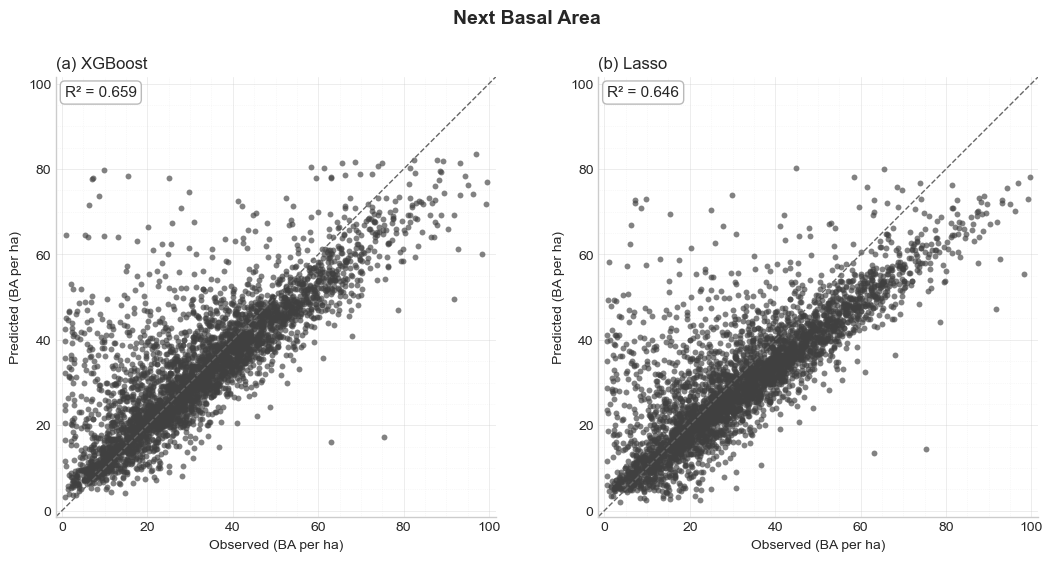

Saved: actual_vs_predicted_broadleaf_conifer.png


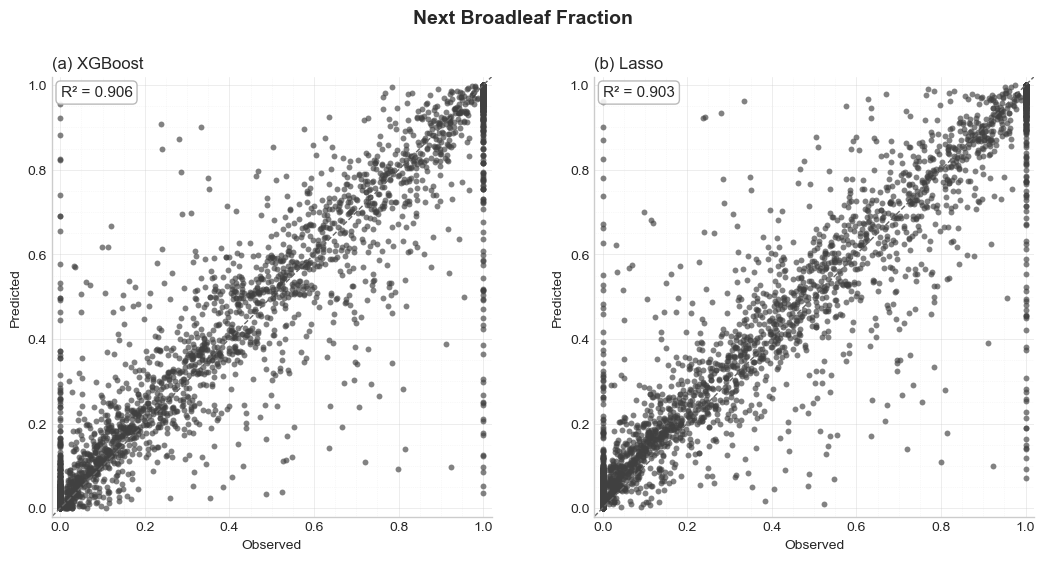

In [26]:
# Plot observed vs predicted for each target and model

def plot_observed_vs_predicted(plot_data):

    targets = {
        'BASFPH_next_INVNR': {
            'file': 'actual_vs_predicted_basal_area.png',
            'title': 'Next Basal Area'
        },
        'HWSW_prop_next_INVNR': {
            'file': 'actual_vs_predicted_broadleaf_conifer.png',
            'title': 'Next Broadleaf Fraction'
        }
    }

    for target, cfg in targets.items():
        d = plot_data.get(target, {}) 
        y = d.get('y_true'); yx = d.get('XGBoost'); yl = d.get('Lasso')
        if y is None or yx is None or yl is None:
            print(f"Skipping {target}: missing data."); continue

        fig, axes = plt.subplots(1, 2, figsize=(11, 5.5))
        fig.suptitle(cfg['title'], fontsize=14, weight='bold', y=0.98)

        # shared limits
        lo = min(y.min(), yx.min(), yl.min())
        hi = max(y.max(), yx.max(), yl.max())
        pad = 0.02 * (hi - lo)
        lo, hi = lo - pad, hi + pad

        for ax, pred, panel_title in zip(axes, [yx, yl], ['(a) XGBoost', '(b) Lasso']):
            # points
            ax.scatter(y, pred, s=18, alpha=0.65, color='0.25', linewidth=0)
            
            # 1:1 line
            ax.plot([lo, hi], [lo, hi], '--', color='0.4', lw=1)

            # clean axes
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)

            # Conditionally add the unit based on the target
            if target == 'BASFPH_next_INVNR':  # Basal area (BA per ha)
                ax.set_xlabel('Observed (BA per ha)')
                ax.set_ylabel('Predicted (BA per ha)')
                ax.set_title(f"{panel_title}", loc='left', fontsize=12)
            else:  # Broadleaf Fraction
                ax.set_xlabel('Observed')
                ax.set_ylabel('Predicted')
                ax.set_title(f"{panel_title}", loc='left', fontsize=12)

            # coordinate raster (grid)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.set_axisbelow(True)  # grid behind points
            ax.grid(True, which='major', linewidth=0.7, alpha=0.35)
            ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.25)

            # stats box
            r2 = r2_score(y, pred)
            stats_text = f"R² = {r2:.3f}"
            ax.text(0.02, 0.98, stats_text,
                    transform=ax.transAxes, va='top', ha='left', fontsize=11,
                    bbox=dict(facecolor='white', edgecolor='0.7', alpha=0.9,
                            boxstyle='round,pad=0.3'))

        plt.tight_layout(pad=1.1, rect=[0, 0, 1, 0.95])
        fig.savefig( "../figures/model_eval/" + cfg['file'], dpi=600, bbox_inches='tight')

        print(f"Saved: {cfg['file']}")
        plt.show()

# Run
plot_observed_vs_predicted(plot_data)



Saved: feature_importance_lasso_simple.png


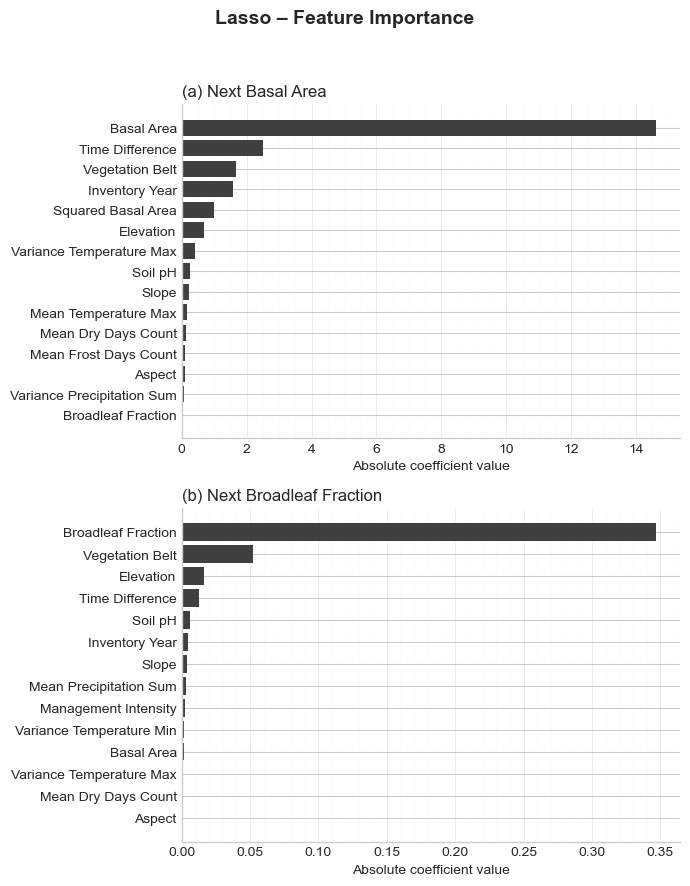

Saved: feature_importance_xgboost_simple.png


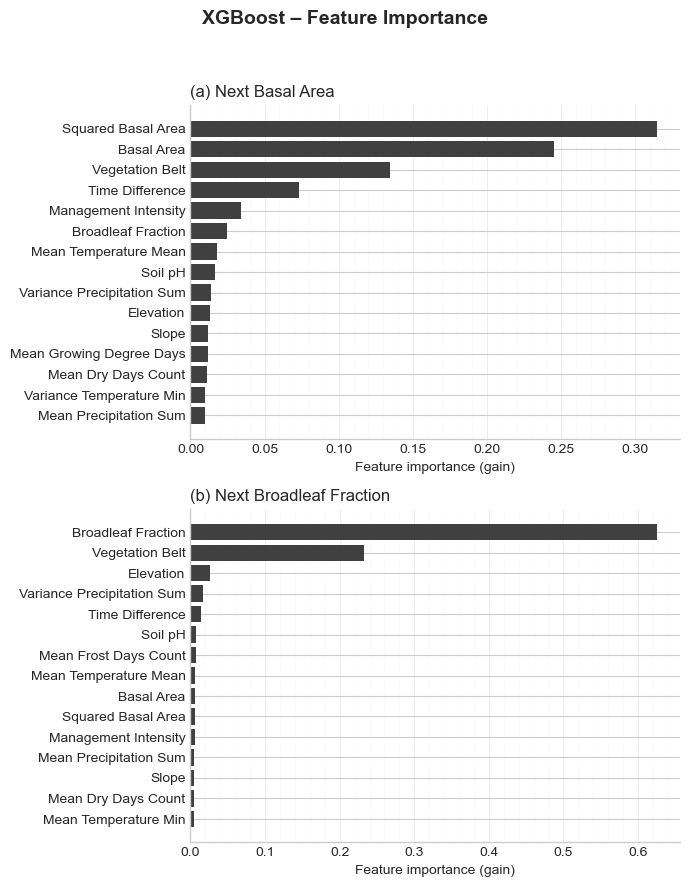

In [27]:
# Plot feature importances for for each target and model

def plot_feature_importances(importances_dict, n_top_features=15):

    # Mapping feature names to more readable names
    feature_name_map = {
        'BASFPH': 'Basal Area', 'BASFPH_squared': 'Squared Basal Area',
        'HWSW_prop': 'Broadleaf Fraction',
        'INVYR': 'Inventory Year', 'Time_Diff_years': 'Time Difference',
        'ASPECT25': 'Aspect', 'SLOPE25': 'Slope', 'PH': 'Soil pH', 'Z25': 'Elevation',
        'mean_tasmin_mean': 'Mean Temperature Min', 'mean_tasmin_variance': 'Variance Temperature Min',
        'mean_tas_mean': 'Mean Temperature Mean', 'mean_tas_variance': 'Variance Temperature Mean',
        'mean_tasmax_mean': 'Mean Temperature Max', 'mean_tasmax_variance': 'Variance Temperature Max',
        'mean_pr_sum': 'Mean Precipitation Sum', 'mean_pr_variance': 'Variance Precipitation Sum',
        'mean_dry_days_count': 'Mean Dry Days Count', 'mean_frost_days_count': 'Mean Frost Days Count',
        'mean_gdd_sum': 'Mean Growing Degree Days',
        'BEWIRTINT1': 'Management Intensity', 'NAISHSTKOMB': 'Vegetation Belt'
    }

    # Function to aggregate categorical features
    def aggregate_cats(series, cat_bases):
        # Initialize categorical sums as 0
        cat_sums = {base: 0.0 for base in cat_bases}

        # Iterate over series to aggregate categorical features
        for feat, val in series.items():
            for base in cat_bases:
                if feat.startswith(base + "_"):
                    cat_sums[base] += val
                    break
            else:
                cat_sums[feat] = val  # Directly assign non-categorical features

        # Convert the result to a pandas Series and return
        return pd.Series(cat_sums, dtype=float)

    # Targets and xlabels for the plots
    targets = {
        'BASFPH_next_INVNR': 'Next Basal Area',
        'HWSW_prop_next_INVNR': 'Next Broadleaf Fraction'
    }
    xlabels = {'Lasso': 'Absolute coefficient value', 'XGBoost': 'Feature importance (gain)'}
    cat_bases = ['BEWIRTINT1', 'NAISHSTKOMB']

    # Loop over models (Lasso and XGBoost)
    for model in ['Lasso', 'XGBoost']:
        fig, axes = plt.subplots(2, 1, figsize=(7, 9))
        fig.suptitle(f"{model} – Feature Importance", fontsize=14, weight="bold")

        # Loop over targets (BASFPH_next_INVNR, HWSW_prop_next_INVNR)
        for i, (target, title_txt) in enumerate(targets.items()):
            ax = axes[i]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Aggregate and filter the feature importances
            s = aggregate_cats(importances_dict[target][model], cat_bases)
            s = s[s > 0].nlargest(n_top_features).sort_values(ascending=True)
            s.index = [feature_name_map.get(n, n) for n in s.index]

            # Plot the bar chart
            ax.barh(s.index, s.values, color='0.25')
            ax.set_title(f"({chr(97+i)}) {title_txt}", loc='left', fontsize=12)
            ax.set_xlabel(xlabels.get(model, 'Importance'))           

            # Adjust plot limits and grid
            ax.set_xlim(0, s.max() * 1.05)
            ax.set_axisbelow(True)  # grid behind bars
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.grid(True, which='major', axis='x', linewidth=0.7, alpha=0.35)
            ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.25)

            ax.tick_params(axis='y', labelsize=10)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        fname = f"feature_importance_{model.lower()}_simple.png"
        fig.savefig( "../figures/model_eval/" + fname, dpi=600, bbox_inches="tight")
        print(f"Saved: {fname}")
        plt.show()



#Run
plot_feature_importances(feature_importances, n_top_features=15)



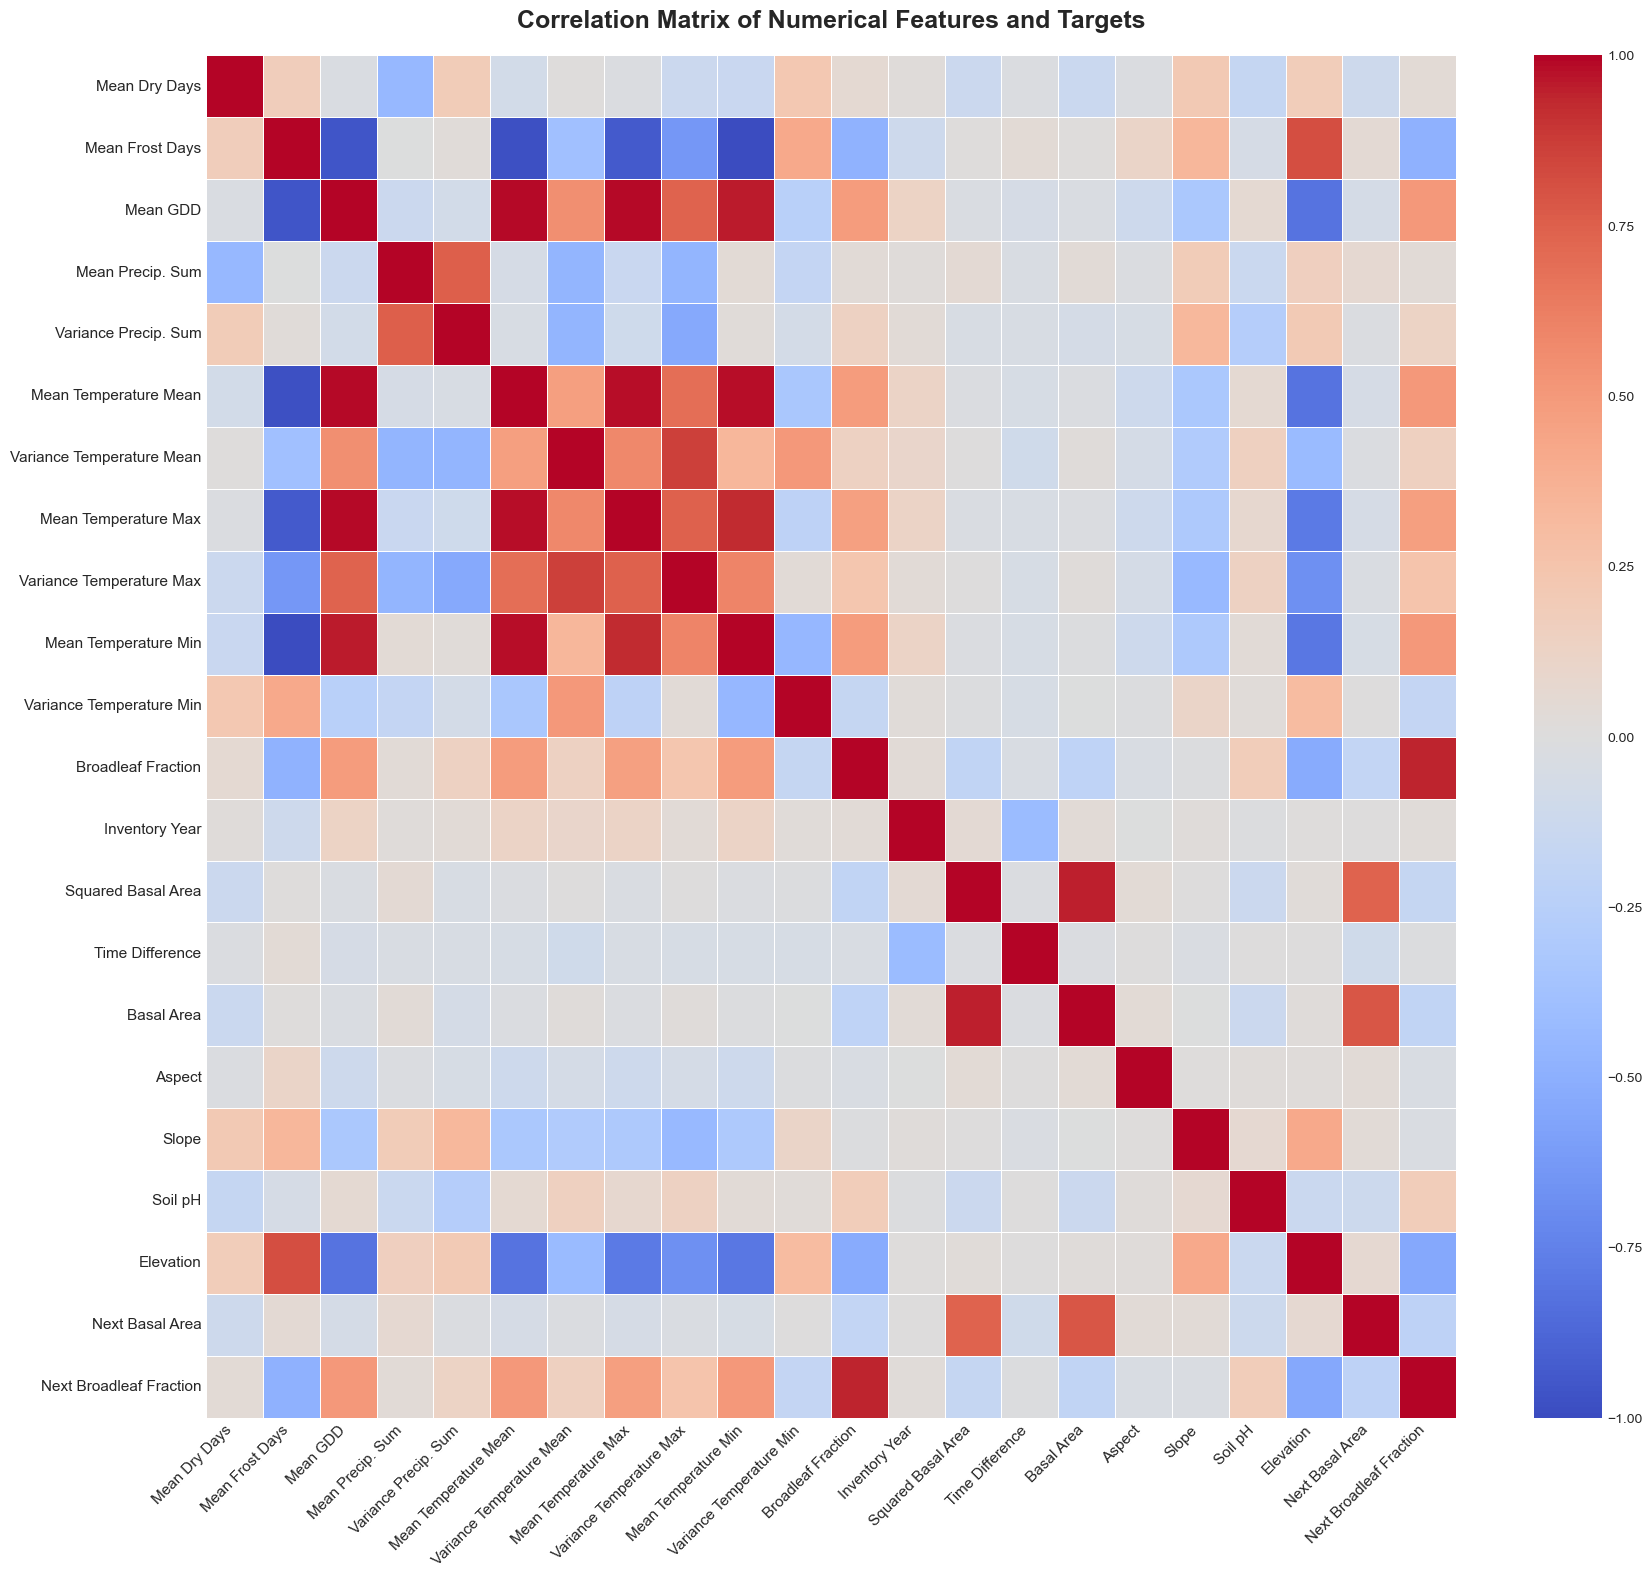

In [28]:
# Create a correlation heatmap of numerical features and targets

def create_correlation_heatmap(df_train, df_test, features, categorical_features):

    # Combine train and test data and select numeric features
    df = pd.concat([df_train, df_test], ignore_index=True)
    num_feats = [f for f in features if f not in categorical_features]
    corr = df[num_feats + TARGETS].corr()
    
    # Mapping feature names to more readable names
    name_map = {
        'BASFPH': 'Basal Area', 'BASFPH_squared': 'Squared Basal Area', 'HWSW_prop': 'Broadleaf Fraction',
        'INVYR': 'Inventory Year', 'Time_Diff_years': 'Time Difference', 'ASPECT25': 'Aspect',
        'SLOPE25': 'Slope', 'PH': 'Soil pH', 'Z25': 'Elevation',
        'mean_tasmin_mean': 'Mean Temperature Min', 'mean_tasmin_variance': 'Variance Temperature Min',
        'mean_tas_mean': 'Mean Temperature Mean', 'mean_tas_variance': 'Variance Temperature Mean',
        'mean_tasmax_mean': 'Mean Temperature Max', 'mean_tasmax_variance': 'Variance Temperature Max',
        'mean_pr_sum': 'Mean Precip. Sum', 'mean_pr_variance': 'Variance Precip. Sum',
        'mean_dry_days_count': 'Mean Dry Days', 'mean_frost_days_count': 'Mean Frost Days',
        'mean_gdd_sum': 'Mean GDD',
        'BASFPH_next_INVNR': 'Next Basal Area',
        'HWSW_prop_next_INVNR': 'Next Broadleaf Fraction',
    }
    corr = corr.rename(index=lambda x: name_map.get(x, x),
                       columns=lambda x: name_map.get(x, x))

    # Plot correlation heatmap
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 16))
    ax = sns.heatmap(
        corr,
        annot=False,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        linewidths=0.5
    )
    ax.set_title('Correlation Matrix of Numerical Features and Targets',
                 fontdict={'fontsize': 18, 'fontweight': 'bold'}, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout(pad=1.5)

    # Save the plot
    fname = "feature_correlation_matrix.png"
    plt.savefig("../figures/nfi_ch2018/" + fname
    , dpi=300, bbox_inches='tight')
    plt.show()


#Run
create_correlation_heatmap(
        train_df_original, 
        test_df_original, 
        FEATURES, 
        CATEGORICAL_FEATURES
    )